In [1]:
from copy import deepcopy
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-03-07 01:30:16 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-07 01:30:16 INFO: Use device: gpu
2021-03-07 01:30:16 INFO: Loading: tokenize
2021-03-07 01:30:19 INFO: Loading: pos
2021-03-07 01:30:20 INFO: Loading: lemma
2021-03-07 01:30:20 INFO: Loading: depparse
2021-03-07 01:30:20 INFO: Done loading processors!
2021-03-07 01:30:20 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-07 01:30:20 INFO: Use device: gpu
2021-03-07 01:30:20 INFO: Loading: tokenize
2021-03-07 01:30:20 INFO: Done loading processors!


In [2]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [3]:
from sentence_transformers import SentenceTransformer, util
sentenceTransformer = SentenceTransformer("roberta-large-nli-stsb-mean-tokens")

In [4]:
def inference_sts(seq1s, seq2s):
    embeddings1 = sentenceTransformer.encode(seq1s, convert_to_tensor=True)
    embeddings2 = sentenceTransformer.encode(seq2s, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    #print("Similarity Score: {:.4f}".format(cosine_scores[0][0]))
    return cosine_scores[0][0]

In [5]:
from pattern.en import pluralize, singularize
from copy import copy
import re

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.hypothesis = ""
        self.tree_log = []
        self.sent_log = []
        self.stop_critarion = False
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', 
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            "appos", 'compound:ptr']
        self.mod_at_right = []
        self.mod_symmetric = ["conj", "compound"]
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.stop_critarion = False
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree
        self.original = original  
        self.annotated = deepcopy(annotated)

        pop_list = list(annotated.popkeys())
        unziped = list(zip(*pop_list))
        self.sentence = list(unziped[0])
       
        self.generate(self.deptree)

    def generate(self, tree):
        if self.stop_critarion:
            return

        if tree.val in self.mod_at_left:
            self.left_modifier_generate(tree)
        elif tree.val in self.mod_symmetric:
            self.symmetric_generate(tree)
        self.generate_default(tree)

    def delete_cc(self, tree):
        if tree.val == "cc" and tree.left.val != "but":
            self.delete_modifier(tree, tree.right)

        if tree.is_tree:
            self.delete_cc(tree.left)
            self.delete_cc(tree.right)

    def delete_modifier(self, tree, modifier):
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right

        self.delete_cc(tree)

    def delete_left_modifier(self, tree):
        self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)
        self.delete_cc(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        disjunction = False
        if tree.val == "conj":
            disjunction = self.search_dependency('or', tree.left)

        if left.mark == "+" or left.mark == "=" or disjunction:
            self.delete_right_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)    
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        disjunction = False
        if tree.val == "conj":
            disjunction = self.search_dependency('or', tree.left)

        if right.mark == "+" or right.mark == "=" or disjunction:
            self.delete_left_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)   

        self.generate(tree.left)
        self.generate(tree.right)
    
    def return_last_leaf(self, tree):
        min_id = 0
        min_id_l = 0
        min_id_r = 0

        if tree.id != None:
            min_id = int(tree.id)
    
        if tree.left.is_tree:
            min_id_l = self.return_last_leaf(tree.left)
        else:
            min_id_l = tree.left.id

        if tree.right.is_tree:
            min_id_r = self.return_last_leaf(tree.right)
        else:
            min_id_r = tree.right.id

        return max(min_id, max(min_id_l, min_id_r))

    def add_modifier_sent(self, tree, modifier, direct=0): 
        last_leaf = self.return_last_leaf(tree)
        sentence = deepcopy(self.sentence)
        if direct == 0:
            sentence.insert(last_leaf-1, modifier)
        elif direct == 1:
            sentence.insert(last_leaf, modifier)

        self.remove_adjcent_duplicate(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.replace("-", " ")
        sentence = sentence.replace(" 's", "'s")

        if abs(len(sentence) - len(self.hypothesis)) < 15:
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip() 
           
            #print(self.Diff(sentence.split(' '), self.hypothesis.split(' ')))
            
            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
                
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.90:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def add_modifier_lexical(self, tree, modifier, head, word_id, direct=0):
        if direct == 0:
            generated = ' '. join([modifier, head])
        else:
            generated = ' '. join([head, modifier])
        
        sentence = deepcopy(self.sentence)
        diff = 0
        if word_id > len(sentence):
            diff = word_id - len(sentence)
        
        goal = word_id-1-diff
        sentence[goal] = "DEL"
        sentence[goal:goal] = generated.split(' ')
        
        if abs(len(sentence) - len(self.hypothesis.split(' '))) < 7:
            self.remove_adjcent_duplicate(sentence)
            sentence = ' '.join(sentence)
            sentence = sentence.replace("DEL ", "")
            sentence = sentence.replace("DEL", "")
            sentence = sentence.replace("-", " ")
            sentence = sentence.replace(" 's", "'s")
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip()

            #print(self.Diff(sentence.split(' '), self.hypothesis.split(' ')))

            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
            
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.9:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def generate_default(self, tree):
        if tree.pos is not None:
            if "NN" in tree.pos and tree.mark == "-":
                for rel in ["amod", "compound", "det", "mark", "nmod:poss", "flat", "conj"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                for rel in ["amod", "acl:relcl", "compound", "acl", "nmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)
                
            elif "VB" in tree.pos and tree.mark == "-":
                for rel in ["advmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)
            
            """elif "JJ" in tree.pos and tree.mark == "-":
                for rel in ["amod", "advmod", "conj"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)"""

        elif tree.val in ["aux", "obj", "obl", "xcomp", "aux:pass", "obl:tmod", "obl:npmod",] and tree.mark == "-":
            for rel in ["advcl", "xcomp", "advmod", "obl", "obl:tmod", "parataxis", "conj"]:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=1)

        if tree.is_tree:
            self.generate(tree.left)
            self.generate(tree.right)  

    def save_tree(self, isTree):
        if isTree:
            leaves = self.deptree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            self.tree_log.append(self.deptree.copy())
        else:
            annotated_cp = deepcopy(self.annotated)
            self.sent_log.append(
                ' '.join([word[0] for word in list(annotated_cp.popkeys())]))
    
    def remove_adjcent_duplicate(self, string):
        to_remove = -1
        for i in range(len(string)-1):
            if string[i] == string[i+1]:
                to_remove = i
        if to_remove > -1:
            del string[to_remove]

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None:
                right_found = self.search_dependency(deprel, right)

            if left is not None:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
    
    def Diff(self, li1, li2):
        return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))    
    
    def preprocess(self, sentence):
        preprocessed = sentence.replace(".", "").replace("!", "").replace("?", "")
        preprocessed = preprocessed.replace("can't", "can not")
        preprocessed = preprocessed.replace("couldn't", "could not")
        preprocessed = preprocessed.replace("don't", "do not")
        preprocessed = preprocessed.replace("doesn't", "does not")
        preprocessed = preprocessed.replace("isn't", "is not")
        preprocessed = preprocessed.replace("won't", "will not")
        preprocessed = preprocessed.replace("wasn't", "was not")
        preprocessed = preprocessed.replace("weren't", "were not")
        preprocessed = preprocessed.replace("didn't", "did not")
        preprocessed = preprocessed.replace("aren't", "are not")
        preprocessed = preprocessed.replace("it's", "it is")
        return preprocessed

In [6]:
modifier_relation = {
    "NN": ["amod", "nmod", "acl:relcl", "fixed", "compound", "det", "nmod:poss", "conj"],
    "VB": ["advmod", "acl", "obl", "xcomp", "advcl", "obl:tmod", "parataxis"]
}

def collect_modifiers(tree, sent_set, mod_type="NN"):
    leaves = []
    if tree.is_tree:
        if tree.val in ["mark", "case", "compound", "flat"]:
            leaves.append(
                (list(tree.right.sorted_leaves().popkeys()),
                tree.left.val)
            )
        if tree.val in modifier_relation[mod_type]:
            leaves.append(
                (list(tree.left.sorted_leaves().popkeys()),
                tree.right.val)
            )

        for leave in leaves:
            if len(leave) > 0 and len(leave) < 10:
                head = leave[1]
                modifier = ' '.join([x[0] for x in leave[0]])
                if tree.val in sent_set:
                    sent_set[tree.val].append({'head': head,'mod': modifier})
                else:
                    sent_set[tree.val] = [{'head': head,'mod': modifier}]

        
        collect_modifiers(tree.left, sent_set, mod_type)
        collect_modifiers(tree.right, sent_set, mod_type)

In [7]:
MED_upward = []
MED_upward_hypo = []
MED_downward = []
MED_downward_hypo = []

with open("../data/MED/upward.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        MED_upward.append(lines[i*4+1])
        MED_upward_hypo.append(lines[i*4+2])

with open("../data/MED/downward.txt") as donward_med:
    lines = donward_med.readlines()
    for i in range(len(lines) // 4):
        MED_downward.append(lines[i*4+1])
        MED_downward_hypo.append(lines[i*4+2])

In [8]:
print(len(MED_downward))

1738


In [12]:
from tqdm import tqdm

annotations = []
with open("./generation_log_donward.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    pipeline = PolarizationPipeline(verbose=0)
    for i in tqdm(range(901, 903)):
        premise = MED_downward[i].replace('\n', '')
        hypothesis = MED_downward_hypo[i].replace('\n', '')
        premise = phrasalGenerator.preprocess(premise)
        hypothesis = phrasalGenerator.preprocess(hypothesis)

        try:
            h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
            h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
        except:
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            continue
        pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")

        try:
            annotation = pipeline.single_polarization(premise)
        except:
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            continue
    
        phrasalGenerator.kb = phrases
        #print(phrasalGenerator.kb)
        phrasalGenerator.hypothesis = hypothesis.replace(',', '')
        
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], 
            annotation['original'])

        for gen_tree in phrasalGenerator.tree_log:
            leaves = gen_tree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            
        if not phrasalGenerator.stop_critarion:
            generate_log.write("\nID: " + str(i))
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            #print("\nPremise: " + premise)
            #print("\nHypothesis: " + hypothesis)
            #print(*phrasalGenerator.sent_log, sep="\n")
            #generate_log.writelines(phrasalGenerator.sent_log)
            generate_log.write('\n')

100%|██████████| 2/2 [00:00<00:00,  3.65it/s]




Init Premise: He is no ordinary student

Hypothesis: He is no ordinary master's student
{'nmod:poss': [{'head': 'cop', 'mod': "no ordinary master 's"}], 'det': [{'head': 'amod', 'mod': 'no'}], 'amod': [{'head': 'case', 'mod': 'ordinary'}], 'case': [{'head': "'s", 'mod': 'master'}, {'head': "'s", 'mod': 'master'}]}


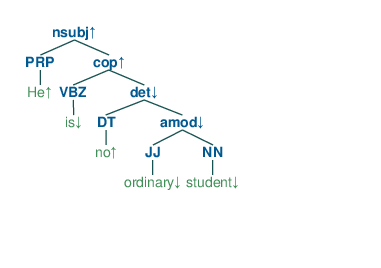

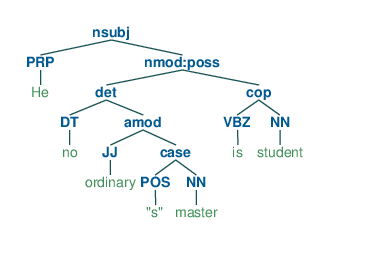

("He is no ordinary no ordinary master's student", tensor(0.9624))
("He is no ordinary no ordinary master's student", tensor(0.9624))
False


In [13]:
up = ["He is no ordinary student"]
up_h = ["He is no ordinary master's student"]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    premise = up[i]
    hypothesis = up_h[i]
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    print("\n====================================")
    print("\nInit Premise: " + premise)
    print("\nHypothesis: " + hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    pipeline.modify_replacement(h_tree, replaced)
    phrases = {} 
    collect_modifiers(h_tree, phrases, mod_type="NN")
    collect_modifiers(h_tree, phrases, mod_type="VB")
    annotation = pipeline.single_polarization(premise)
    
    phrasalGenerator.kb = phrases
    phrasalGenerator.hypothesis = hypothesis.replace(',', '')
    print(phrasalGenerator.kb)
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    polarized = pipeline.postprocess(h_tree, {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz)
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], 
        annotation['original'])

    for gen_tree in phrasalGenerator.tree_log:
        leaves = gen_tree.sorted_leaves().popkeys()
        sentence = ' '.join([x[0] for x in leaves])
        print("\nNext Premise: " + sentence)

    print(*phrasalGenerator.sent_log, sep="\n")
    print(phrasalGenerator.stop_critarion)

In [ ]:
inference_sts(["Tom seldom eats Italian spicy food"], ["Tom seldom eats Italian spicy food"])

In [21]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))

Diff("Tom seldom eats Italian spicy food ".split(' '), "Tom seldom eats Italian spicy food".split(' '))

['']

In [ ]:
sentences = ["Some red flowers need light", 
             "Some red and beautiful flowers need light",
             "All flowers need light and water", 
             "No flowers need bright or warm light",
             "John can sing and dance",
             "John ate an apple and finished his homework",
             "John finished his homework and did not eat an apple"]

upward = ["Some students sing to celebrate their graduation",
          "An Irishman won the nobel prize for literature.",
          "A big poison spider was spanning a web", 
          "A Californian special policeman pulled a car over and spoke to the driver",
          "A woman is dancing in a cage", 
          "A woman is dancing beautifully in a cage", 
          "People are riding and paddling a raft", 
          "Some delegates finished the survey on time"]

sick_upward = ["A brown dog is attacking another animal in front of the tall man in pants",
               "A skilled person is riding a bicycle on one wheel",
               "Two children are lying in the snow and are drawing angels"]

downward = ["No spider was spanning a web",
            "No student finished homework",
            "I've never flown in an airplane"]

hypothesis = ["No poison spider was spanning a web", 
              "No student at school finished homework compeletly",
              "I've never flown in an airplane because i'm afraid."] 

In [ ]:
disp = plot_confusion_matrix(
    classifier, X_test, y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=normalize)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.show()